We're gonna stress-test the strip methods.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
from PIL import Image

In [2]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [3]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [4]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

In [5]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [6]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [7]:
def getCropped(X, thresh=0.01):
    ll, w, h = getBoundingBox(X, thresh=thresh)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

In [8]:
def getStripBoundaries(X, showPlot = False, debug=False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    if debug:
        print("X filter:")
        plt.imshow(Xfilt)
        print("rsum is: " +  str(rsum))
        print("rsum spectra: " + str(rsum_spectra))
        print("spectra max: " + str(spectra_max))
    
    # determine boundaries
    numStrips = np.int(len(peakidxs))
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[i]
        if i >= (numStrips - 1):
            break
        peak2idx = peakidxs[i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [9]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

In [10]:
def getStrips(X, bnds):
    strips = []
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [11]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [12]:
def locateStaffLines(s, delta = 3, debug=False):
    medvals = np.median(s, axis=1)
    if debug:
        print("num medvals: " + str(len(medvals)))
        print("medvals are: " +  str(medvals))
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10]) # going to change from [0:10] to [0:10] skipping by 2
    idxs_lines = idxs_lines[1::2] # we want just 5, so start at the second and skip every other.
    if debug:
        print("sorted idxs val before clip: " + str(idxs_sorted_val))
        print("num sorted idxs: " + str(len(idxs_sorted_val)))
        print("idxs_lines number after clip: " + str(len(idxs_lines)))
        print("idxs_lines: " + str(idxs_lines))
    return np.array(idxs_lines)

In [13]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs):
    x = np.array([4, 2, 0, -2, -4]) # midi nums for staff lines, reformatted to be 0 in the middle, etc.
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [14]:
def estimatePixelRow (midinum, m, b):
    return np.int(np.round(midinum * m + b))

In [15]:
def estimatePixelRow2MidiNumMapping(s, lineIdxs):
    x = np.array([4, 2, 0, -2, -4]) # midi nums for staff lines
    m, b, _, _, _ = linregress(lineIdxs, x)
    return (m,b)

In [16]:
def getStripBoundariesNonPiano(X, showPlot = False, debug = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    if debug:
        print("X filter:")
        plt.imshow(Xfilt)
        print("rsum is: " +  str(rsum))
        print("rsum spectra: " + str(rsum_spectra))
        print("spectra max: " + str(spectra_max))
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) # note the lack of -1 here
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i]
        peak2idx = peakidxs[2*i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [17]:
pics = os.listdir('pdf/mini_dataset_png')

In [18]:
pic_names = []
for pic in pics:
    name = os.path.join('pdf/mini_dataset_png', pic)
    pic_names.append(name)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


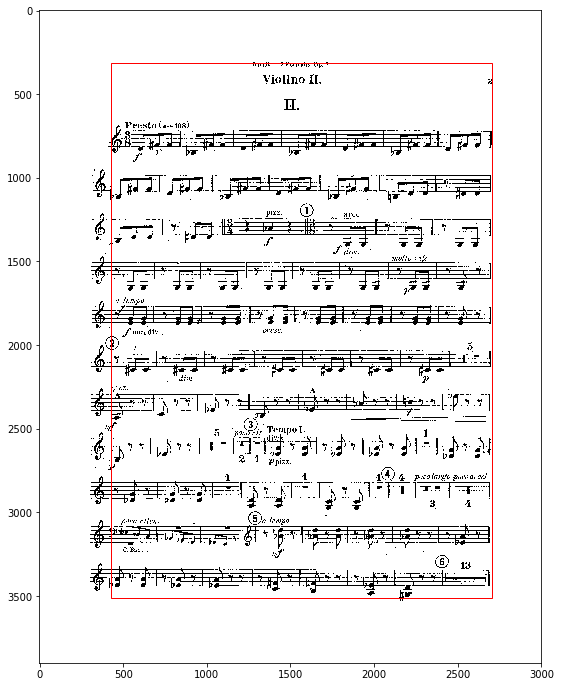

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


visualizing boundaries...
showing bounding box image...


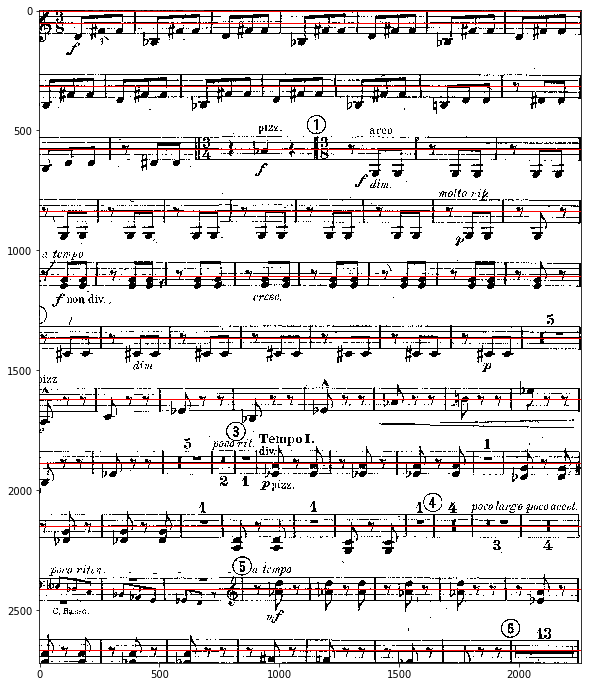

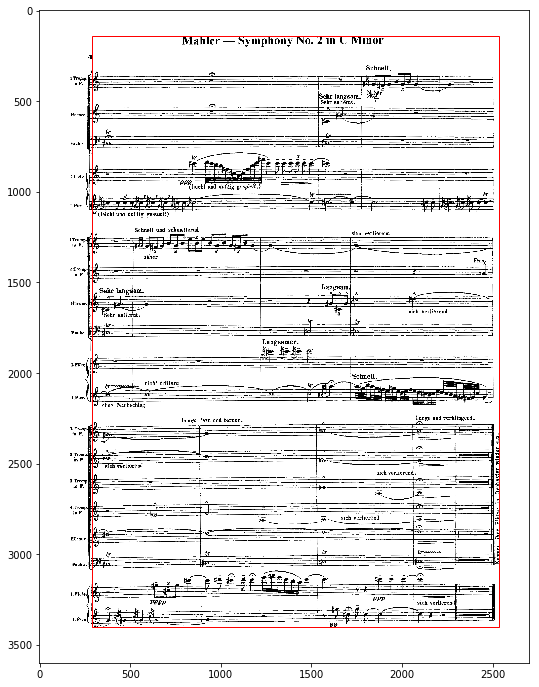

visualizing boundaries...
showing bounding box image...


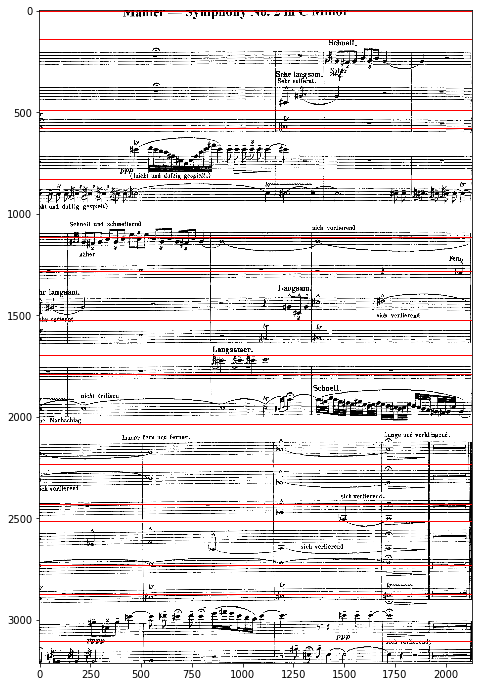

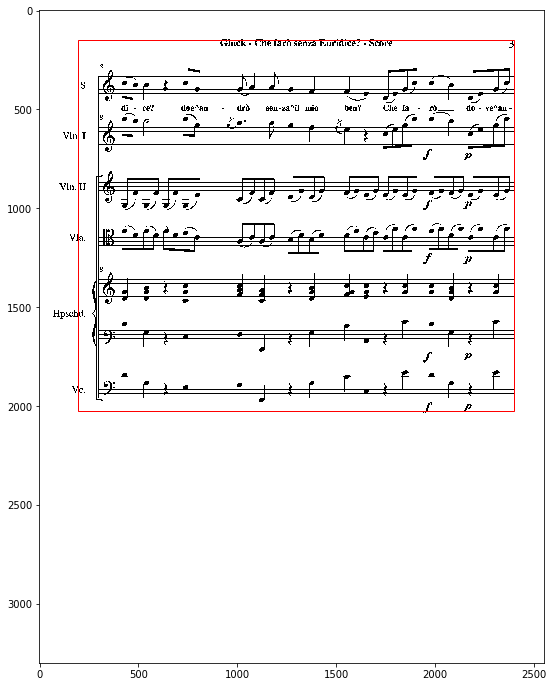

visualizing boundaries...
showing bounding box image...


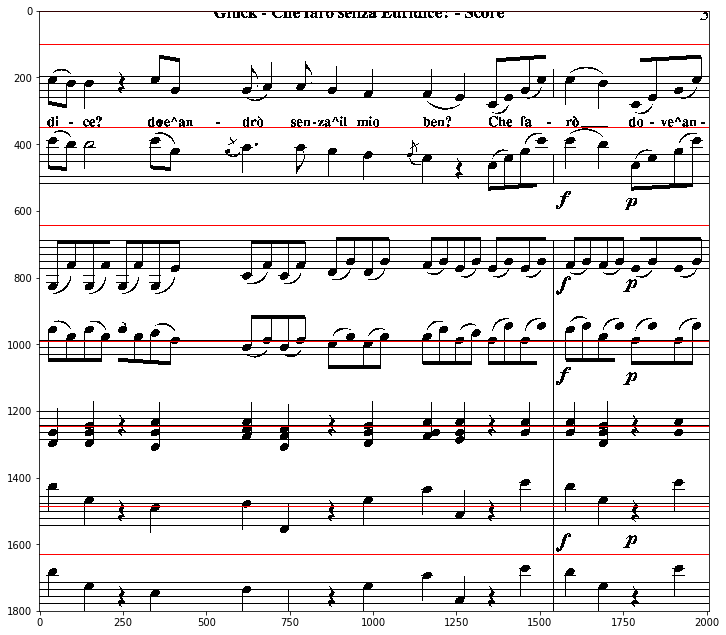

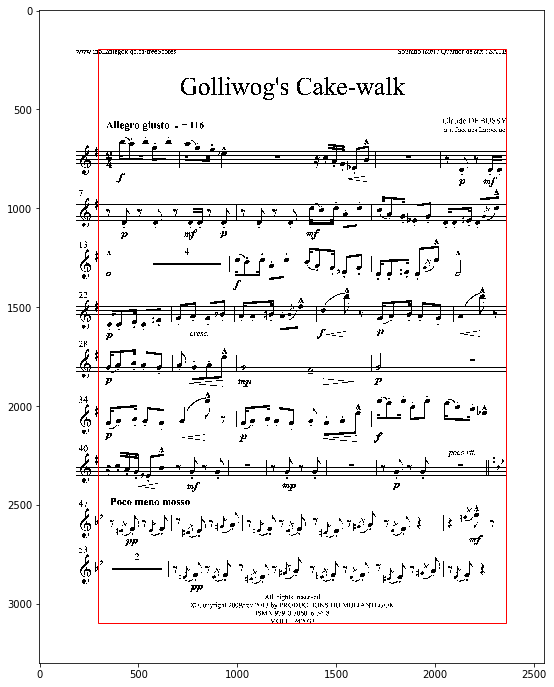

visualizing boundaries...
showing bounding box image...


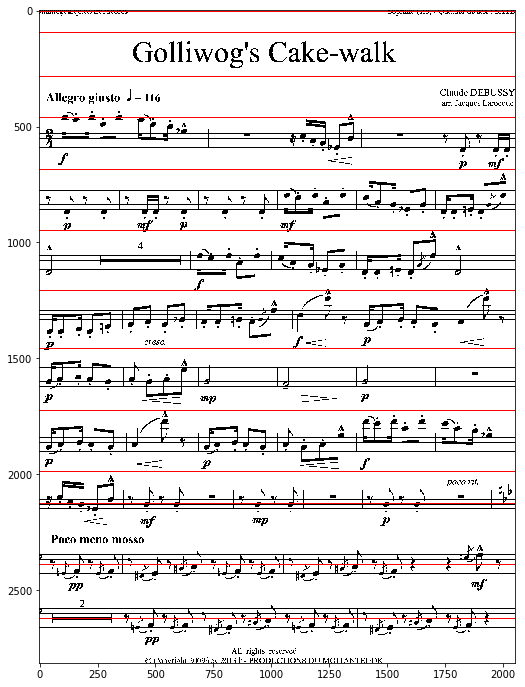

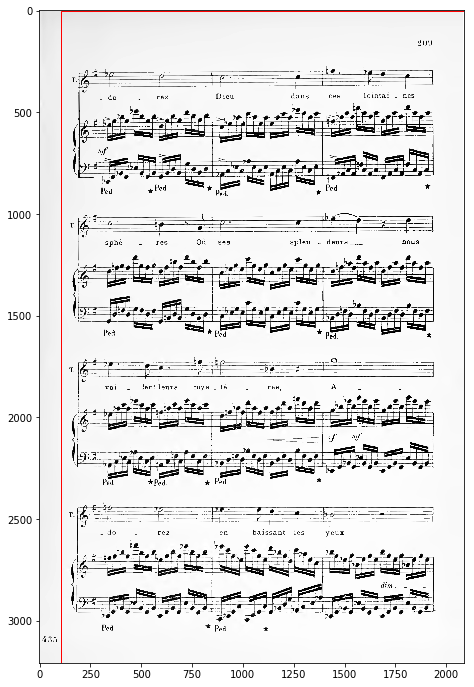

visualizing boundaries...
showing bounding box image...


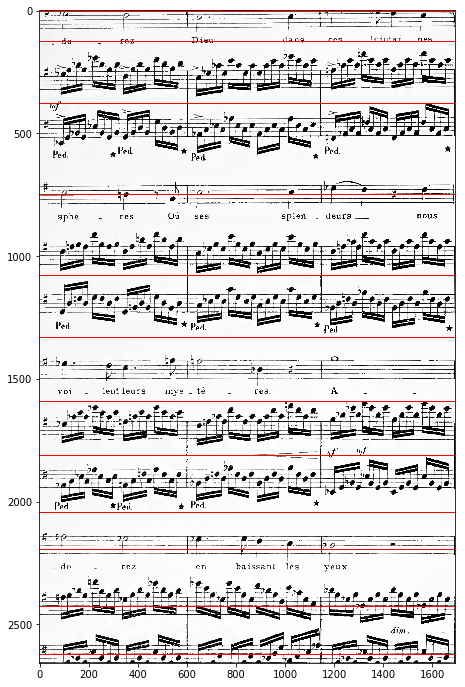

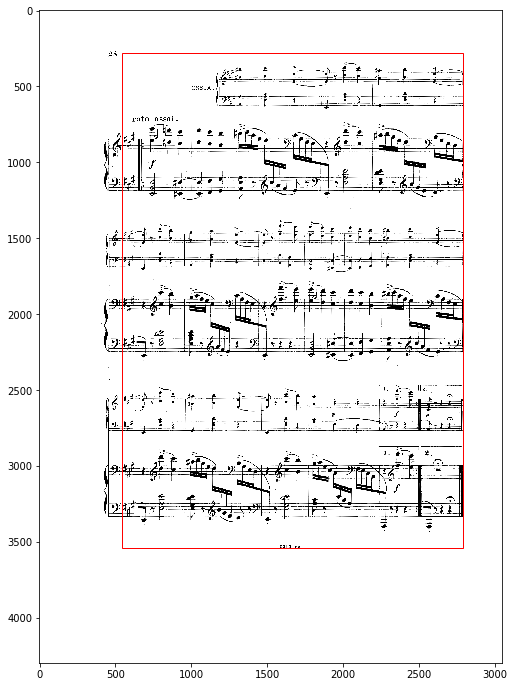

visualizing boundaries...
showing bounding box image...


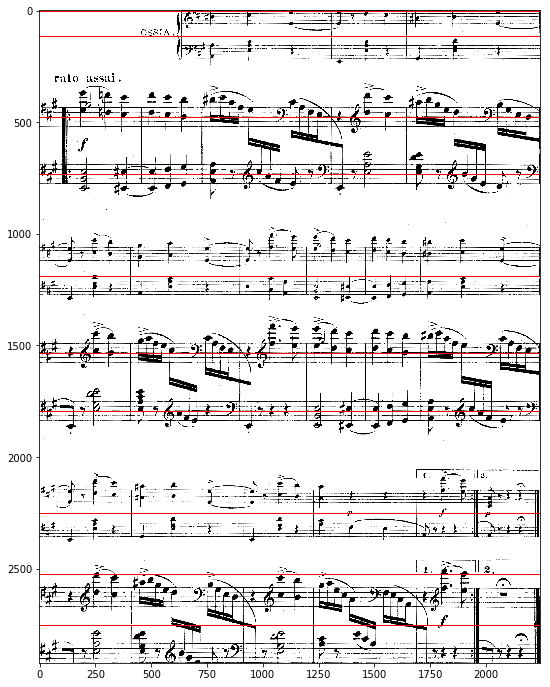

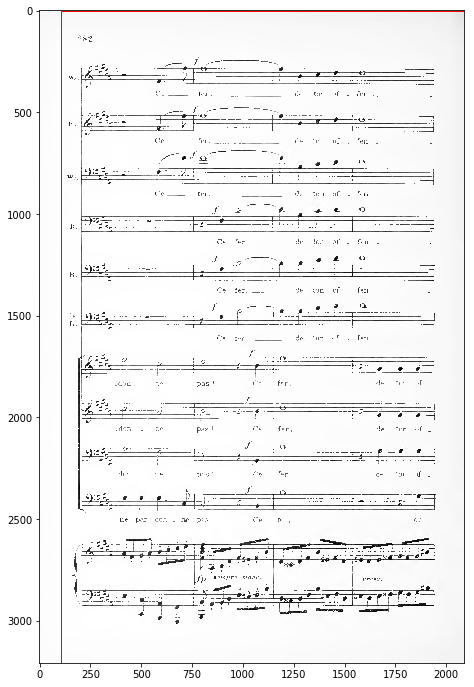

visualizing boundaries...


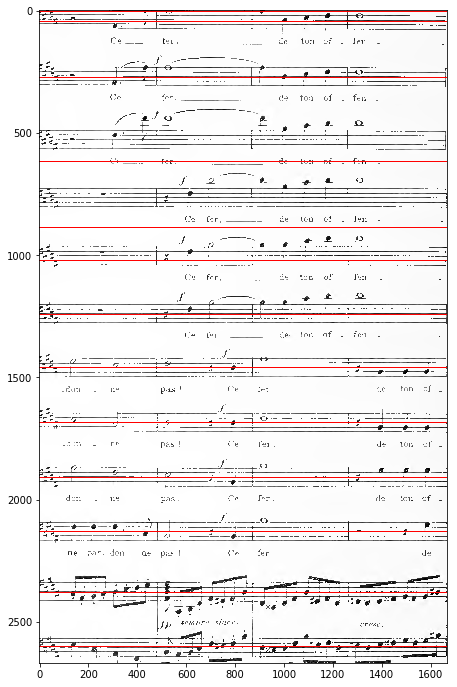

In [19]:
for pic in pic_names[0:7]:
    I = importImage(pic)
    Irot, theta = rotateToHorizontal(I)
    ll, bbw, bbh = getBoundingBox(Irot)
    print("showing bounding box image...")
    showImageWithBB(Irot, ll, bbw, bbh)
    Icrop = getCropped(Irot, thresh=0.2)
    bnds = getStripBoundariesNonPiano(Icrop)
    print("visualizing boundaries...")
    visualizeBoundaries(Icrop, bnds)